<a href="https://colab.research.google.com/github/Immaraju/Data-Science-Assignment-eCommerce-Transactions-Dataset-/blob/main/immaraju_srilekha_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

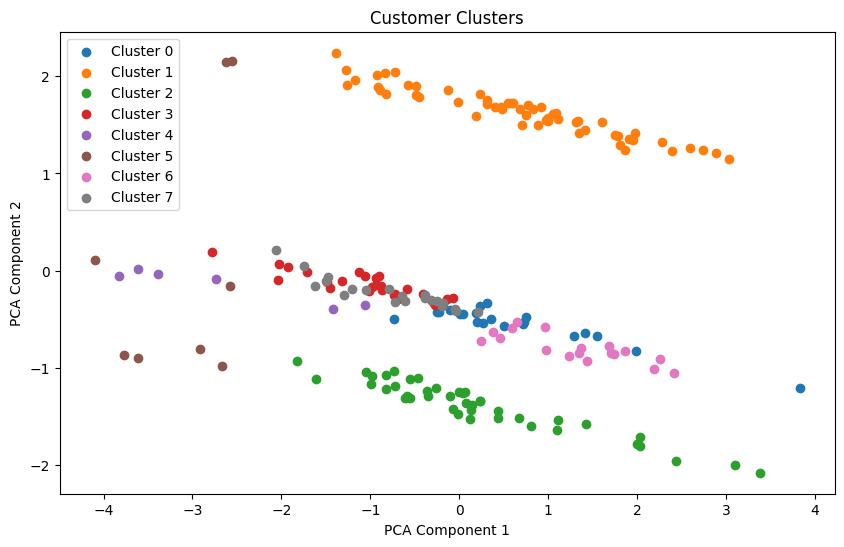

Optimal number of clusters: 8
Davies-Bouldin Index for optimal clustering: 0.9084820699856484


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Step 1: Load and Merge Data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Calculate customer-level transaction data
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Number of transactions
    'TransactionDate': lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days  # Recency
}).reset_index()

transaction_summary.columns = ['CustomerID', 'TotalSpending', 'TransactionCount', 'Recency']

# Merge with customer profile
customer_data = customers.merge(transaction_summary, on='CustomerID', how='left')

# Step 2: Feature Engineering
# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_region = encoder.fit_transform(customer_data[['Region']])

# Combine all features
features = pd.concat(
    [customer_data[['TotalSpending', 'TransactionCount', 'Recency']],
     pd.DataFrame(encoded_region, index=customer_data.index)],
    axis=1
)

# Fill missing values with 0
features.fillna(0, inplace=True)

# Ensure all column names are strings
features.columns = features.columns.astype(str)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 3: Clustering and Evaluation
# Test different numbers of clusters (k)
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append((k, db_index))

# Identify the best number of clusters (lowest DB Index)
best_k = min(db_scores, key=lambda x: x[1])[0]

# Fit the final model
kmeans = KMeans(n_clusters=best_k, random_state=42)
final_labels = kmeans.fit_predict(scaled_features)

# Step 4: Add Cluster Labels to Data
customer_data['Cluster'] = final_labels

# Step 5: Visualize the Clusters
# Optional: Use PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    cluster_points = reduced_features[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title('Customer Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Step 6: Save Results
# Save clustering results
customer_data.to_csv('FirstName_LastName_Clustering.csv', index=False)

print(f"Optimal number of clusters: {best_k}")
print(f"Davies-Bouldin Index for optimal clustering: {min(db_scores, key=lambda x: x[1])[1]}")
